# Intitial Exploration

In [42]:
%run -i Barcelona/Barcelone_code/load_data_barcelone.ipynb

import igraph as ig
import leidenalg
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

def convert_edge_matrix_to_connectivity_matrix(edge_matrix):
  num_elements = max(edge_matrix['Source'].max(), edge_matrix['Target'].max())
  matrix = np.zeros((num_elements + 1, num_elements + 1))
  for (_, row) in edge_matrix.iterrows():
    target_row = row['Source']
    target_col = row['Target']
    matrix[target_row, target_col] = 1
  return matrix

def calculate_weighted_variance(grouped, features):
    total = 0
    for feature in features:
        feature_sum = grouped[f'{feature}'].sum()
        squared_feature_sum = grouped[f'Squared_{feature}'].sum()
        weighted_variance = squared_feature_sum - ((feature_sum * feature_sum) / grouped.size())
        total += weighted_variance.sum()
    return total

def perform_agglomerative_clustering(edge_matrix, node_attributes, num_clusters):
    connectivity_matrix = convert_edge_matrix_to_connectivity_matrix(edge_matrix)
    agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', metric='euclidean', connectivity=connectivity_matrix, compute_distances=True)
    clusters = agg_clustering.fit(node_attributes)
    return clusters

def compare_clustering_result(param, node_attributes, partition, clusters: AgglomerativeClustering, features):
    np_node_attributes = np.array(node_attributes)
    squared_features = np_node_attributes ** 2
    output_df = pd.DataFrame()
    
    if 'Occupancy' in features and 'Speed' in features:
        output_df['Occupancy'] = np_node_attributes[:, 0]
        output_df['Speed'] = np_node_attributes[:, 1]
        output_df['Squared_Occupancy'] = squared_features[:, 0]
        output_df['Squared_Speed'] = squared_features[:, 1]       
    elif ('Speed' in features):
        output_df['Speed'] = np_node_attributes[:, 0]
        output_df['Squared_Speed'] = squared_features[:, 0]
    elif ('Occupancy' in features):
        output_df['Occupancy'] = np_node_attributes[:, 0]
        output_df['Squared_Occupancy'] = squared_features[:, 0]
    
    output_df['Cluster_Contiguity'] = partition.membership
    output_df['Cluster_Agglomerative'] = clusters.labels_

    var_speed_by_contigs = calculate_weighted_variance(output_df.groupby('Cluster_Contiguity'), features=features)
    var_speed_by_aggloms = calculate_weighted_variance(output_df.groupby('Cluster_Agglomerative'), features=features)

    silhouette_contigs = silhouette_score(node_attributes, output_df['Cluster_Contiguity'])
    calinski_contigs = calinski_harabasz_score(node_attributes, output_df['Cluster_Contiguity'])
    davies_bouldin_contigs = davies_bouldin_score(node_attributes, output_df['Cluster_Contiguity'])

    silhouette_agglom = silhouette_score(node_attributes, output_df['Cluster_Agglomerative'])
    calinski_agglom = calinski_harabasz_score(node_attributes, output_df['Cluster_Agglomerative'])
    davies_bouldin_agglom = davies_bouldin_score(node_attributes, output_df['Cluster_Agglomerative'])

    print('-'* 100) 
    print(f'Clustering Analysis')
    print('-'* 100) 
    print(partition.summary())
    print(f'Partition quality: {-(partition.quality() + (param * len(partition)))}')
    print(f'Weighted speed variance of contiguity based clusters:    {var_speed_by_contigs}')
    print(f"Silhouette Score: {silhouette_contigs}")
    print(f"Calinski-Harabasz Index: {calinski_contigs}")
    print(f"Davies-Bouldin Index: {davies_bouldin_contigs}")
    print('-'* 100) 
    print(f'Agglomerative clustering on {clusters.n_clusters_} clusters: ')
    print(f'Sum of distances: {sum(clusters.distances_)}')
    print(f'Weighted speed variance of agglomerative based clusters: {var_speed_by_aggloms}')
    print(f"Silhouette Score: {silhouette_agglom}")
    print(f"Calinski-Harabasz Index: {calinski_agglom}")
    print(f"Davies-Bouldin Index: {davies_bouldin_agglom}")
    return output_df

def manually_optimize_partition(edge_matrix, node_attributes, resolution_parameter, disconnect_penalty, n_iterations):
    graph = ig.Graph.DataFrame(
        edges=edge_matrix, 
        directed=False, 
    )
    kwargs = {
        'node_attributes':node_attributes,
        'resolution_parameter':resolution_parameter,
        'disconnect_penalty':disconnect_penalty,
    }
    partition = leidenalg.ContiguousConstrainedVertexPartition(graph, **kwargs)
    optimiser = leidenalg.Optimiser()
    optimiser.set_rng_seed(42)

    historic_raw_qualities = []
    historic_qualities = []
    historic_community_weights = []
    historic_diffs = []

    itr = 0 
    diff = 0
    continue_iteration = itr < n_iterations or n_iterations < 0
    while continue_iteration:
        diff_inc = leidenalg._c_leiden._Optimiser_optimise_partition(
            optimiser._optimiser,
            partition._partition,
        )   
        partition._update_internal_membership()
        itr += 1
        raw_quality = partition.quality()
        num_clusters = len(partition)
        community_weight = num_clusters * resolution_parameter
        adjusted_quality = (raw_quality *-1) + community_weight
        diff += diff_inc

        historic_raw_qualities.append(raw_quality)
        historic_qualities.append(adjusted_quality)
        historic_community_weights.append(num_clusters)
        historic_diffs.append(diff_inc)

        if n_iterations < 0:
            continue_iteration = (diff_inc > 0)
        else:
            continue_iteration = itr < n_iterations

    return partition, optimiser, historic_raw_qualities, historic_qualities, historic_community_weights, historic_diffs

def get_barcelona_clustering_results(possible_params, features):
    _, _, _, _, _, connectedPairs, AvgOcc_med_NC, SMS_med_NC = load_data('barcelone', root='./Barcelona/Barcelone_data/')
    edge_matrix = pd.DataFrame()
    edge_matrix['Source'] = connectedPairs['upstream_index_order'].astype(int) - 1
    edge_matrix['Target'] = connectedPairs['downstream_index_order'].astype(int) - 1
    time_slice = '05:45:00'
    node_attributes = []
    if 'Occupancy' in features and 'Speed' in features:
        node_attributes = np.column_stack((AvgOcc_med_NC[time_slice].to_numpy(), SMS_med_NC[time_slice].to_numpy()))
    elif ('Occupancy' in features):
        node_attributes = AvgOcc_med_NC[time_slice].to_numpy().reshape(-1, 1)
    elif ('Speed' in features):
        node_attributes = SMS_med_NC[time_slice].to_numpy().reshape(-1, 1)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(node_attributes).tolist()
    
    results = {}

    for param in possible_params:
        partition, optimiser, raw_quality, qualities, community_weights, diffs = manually_optimize_partition(
            edge_matrix=edge_matrix, 
            node_attributes=X, 
            resolution_parameter=param,
            disconnect_penalty=0,
            n_iterations=-1
        )
        clustering = perform_agglomerative_clustering(edge_matrix=edge_matrix, node_attributes=X, num_clusters=len(partition))
        output_df = compare_clustering_result(param, X, partition=partition, clusters=clustering, features=features)
        results[param] = {
            'Partition':partition, 
            'Optimiser': optimiser,
            'Clustering':clustering, 
            'Raw_Quality':raw_quality, 
            'Adjusted_Quality':qualities, 
            'Community_Weight':community_weights, 
            'Diffs':diffs,
            'Output_DF':output_df,
            'Edge_Matrix_DF':edge_matrix
        }
    
    return results


In [3]:
params = [20]
clustering_result = get_barcelona_clustering_results(params, features=['Occupancy', 'Speed'])

/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_26958/2888611198.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  downstream = pd.read_csv(downstream_path, delimiter = '  ', header = None,
/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_26958/2888611198.py:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  connectedPairs = pd.read_csv(connectedPairs_path, delimiter = '  ',
/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_26958/2888611198.py:59: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 ch

----------------------------------------------------------------------------------------------------
Clustering Analysis
----------------------------------------------------------------------------------------------------
Clustering with 1570 elements and 10 clusters
Partition quality: 978.3912961447616
Weighted speed variance of contiguity based clusters:    978.3912961447598
Silhouette Score: -0.037384986026016205
Calinski-Harabasz Index: 382.9539811708823
Davies-Bouldin Index: 8.572463697751237
----------------------------------------------------------------------------------------------------
Agglomerative clustering on 10 clusters: 
Sum of distances: 1349.6245570471322
Weighted speed variance of agglomerative based clusters: 1194.4463866597484
Silhouette Score: -0.3791961530356245
Calinski-Harabasz Index: 282.331042016908
Davies-Bouldin Index: 3.811943111678402


In [63]:
import time as time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

from matplotlib.cm import ScalarMappable

links, downstream, l_d, nodes, positions, connectedPairs, AvgOcc_med_NC, SMS_med_NC = load_data('barcelone', root='./Barcelona/Barcelone_data/', demand_level='High')

/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1226934194.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  downstream = pd.read_csv(downstream_path, delimiter = '  ', header = None,
/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1226934194.py:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  connectedPairs = pd.read_csv(connectedPairs_path, delimiter = '  ',
/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1226934194.py:82: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and

In [79]:
def plot_clusters(clusters, title, filename = ""):
    
    cmap = matplotlib.colormaps['tab10'].colors
    dark = matplotlib.colormaps['Dark2'].colors[-1]

    biggest_cluster = np.argmax(np.bincount(np.array(clusters)))

    plt.figure(figsize=(18,6))
    subplot = plt.subplot(1,2,1)
    links_index = links.index.tolist()
    subplot.xaxis.set_ticklabels([])
    subplot.yaxis.set_ticklabels([])

    for link in links_index:
        cluster = clusters[links_index.index(link)]
        if cluster == biggest_cluster:
            color = dark
        else: 
            color = cmap[cluster]
        subplot.plot(positions.loc[link,['StartNode_X', 'EndNode_X']],
                    positions.loc[link,['StartNode_Y', 'EndNode_Y']],
                    c = color,
        )

    plt.title(title)
    if (filename != ""):
        plt.savefig(fname=filename, bbox_inches='tight')

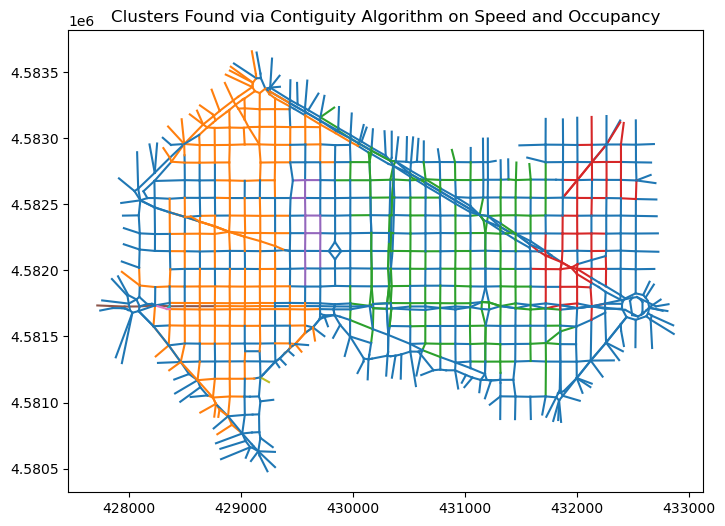

In [132]:
partition = clustering_result[params[0]]['Partition']
clusters = partition.membership
plot_clusters(clusters, 'Clusters Found via Contiguity Algorithm on Speed and Occupancy')

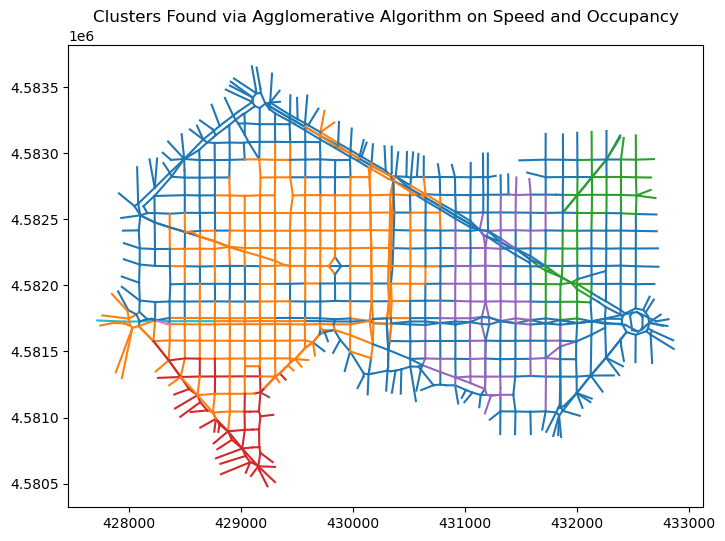

In [133]:
aggl = clustering_result[params[0]]['Clustering']
plot_clusters(aggl.labels_, 'Clusters Found via Agglomerative Algorithm on Speed and Occupancy')

In [117]:
def get_subgraphs_by_clusters(edge_matrix_df, partition):
    subgraphs = {}
    for (comm, count) in enumerate(partition.sizes()):
        subgraphs[comm] = []
        for (vertex, v_comm) in enumerate(partition.membership):
            if (comm == v_comm):
                subgraphs[comm].append(vertex)
        if (len(subgraphs[comm]) != count):
            raise Exception("Counts do not match")
    
    subgraph_edge_matrices = {}
    for (subgraph, vertices) in subgraphs.items():
        matrix = []
        for (index, vertex) in enumerate(vertices):
            edges = edge_matrix_df[edge_matrix_df['Source'] == vertex]
            for row in edges.iterrows():
                source = row[1]['Source']
                target = row[1]['Target']
                if target in vertices:
                    index_of_target = vertices.index(target)
                    if (matrix.count((index_of_target, index)) > 0):
                        continue
                    matrix.append((index, index_of_target))
        subgraph_edge_matrices[subgraph] = matrix
        
    return subgraph_edge_matrices, subgraphs

def find_disconnected_communities(results_map):
    subgraph_edges, subgraph_vertices = get_subgraphs_by_clusters(results_map['Edge_Matrix_DF'], results_map['Partition'])
    for graph_number in range(len(results_map['Partition'])):
        edge_list = subgraph_edges[graph_number]
        vertex_list = subgraph_vertices[graph_number]
        subgraph = ig.Graph(n=len(vertex_list), edges=edge_list, directed=False)
        if (not subgraph.is_connected()):
            print(f"Subgraph {graph_number} is NOT connected")

In [134]:
find_disconnected_communities(clustering_result[params[0]])

In [68]:
len(AvgOcc_med_NC.columns) / 11

21.818181818181817

In [15]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import igraph as ig
import leidenalg
from sklearn.preprocessing import StandardScaler
_, _, _, _, _, connectedPairs, AvgOcc_med_NC, SMS_med_NC = load_data('barcelone', root='./Barcelona/Barcelone_data/', demand_level='Med')

def compare_leiden_algorithm(features):
  edge_matrix = pd.DataFrame()
  edge_matrix['Source'] = connectedPairs['upstream_index_order'].astype(int) - 1
  edge_matrix['Target'] = connectedPairs['downstream_index_order'].astype(int) - 1
  node_attributes = StandardScaler().fit_transform(X=np.column_stack((AvgOcc_med_NC.mean(axis=1).to_numpy(), SMS_med_NC.mean(axis=1).to_numpy())))
  
  graph = ig.Graph.DataFrame(edge_matrix, directed=False)
  squared_attr = node_attributes ** 2
  output_df = pd.DataFrame({'Occupancy':node_attributes[:, 0], 'Speed':node_attributes[:, 1], 'Squared_Occupancy':squared_attr[:, 0], 'Squared_Speed':squared_attr[:, 1]})
  partition = leidenalg.find_partition(graph=graph, partition_type=leidenalg.CPMVertexPartition, n_iterations=-1, **{'resolution_parameter':.0003})
  output_df['Clusters'] = partition.membership
  print('-'*100)
  print(features)
  print(f"Partition length: {len(partition)}")
  print(f"Weighted variance {calculate_weighted_variance(output_df.groupby('Clusters'), features=features)}")
  print(f"sil: {silhouette_score(output_df[features], output_df['Clusters'])}")
  print(f"cal: {calinski_harabasz_score(output_df[features], output_df['Clusters'])}")
  print(f"davies: {davies_bouldin_score(output_df[features], output_df['Clusters'])}")

compare_leiden_algorithm(['Speed'])
compare_leiden_algorithm(['Occupancy'])
compare_leiden_algorithm(['Occupancy', 'Speed'])

/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1226934194.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  downstream = pd.read_csv(downstream_path, delimiter = '  ', header = None,
/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1226934194.py:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  connectedPairs = pd.read_csv(connectedPairs_path, delimiter = '  ',
/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1226934194.py:60: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and

----------------------------------------------------------------------------------------------------
['Speed']
Partition length: 5
Weighted variance 1530.9114203731049
sil: -0.3616252946019953
cal: 9.989739821325621
davies: 21.42717974505476
----------------------------------------------------------------------------------------------------
['Occupancy']
Partition length: 5
Weighted variance 1444.6729637609226
sil: -0.1832306783487818
cal: 33.94138615350579
davies: 6.149657587543301
----------------------------------------------------------------------------------------------------
['Occupancy', 'Speed']
Partition length: 5
Weighted variance 2975.5843841340275
sil: -0.10828889852449884
cal: 21.618479398722723
davies: 8.584935576416964


# Analyzing Data

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

with open(file='./outputs/barcelona_5_clusters_means.json') as f:
    raw_data = json.load(f)

def calc_means(data):
  return sum(data) / len(data)

def output_means(data_segment):
    vars = calc_means(data_segment['weighted_variance'])
    silhouette_score = calc_means(data_segment['silhouette'])
    calinksi = calc_means(data_segment['calinksi'])
    davies = calc_means(data_segment['davies'])
    return round(vars, 4), round(silhouette_score, 4), round(calinksi, 4), round(davies, 4)

for key in raw_data.keys():
  print('-'*100) 
  print(f"EVALUATING {key}")
  contig_vars, contig_sil, contig_cal, contig_dav = output_means(raw_data[key]['contiguity'])
  agglom_vars, agglom_sil, agglom_cal, agglom_dav = output_means(raw_data[key]['agglomerative'])
  print('Contiguity:')
  print(f'\tWeighted Var: {contig_vars}. Silhouette: {contig_sil}. Calinksi: {contig_cal}. Davies: {contig_dav}.')
  print('Ward:')
  print(f'\tWeighted Var: {contig_vars}. Silhouette: {contig_sil}. Calinksi: {contig_cal}. Davies: {contig_dav}.')

----------------------------------------------------------------------------------------------------
EVALUATING med_all
Contiguity:
	Weighted Var: 1952.7639. Silhouette: 0.0043. Calinksi: 238.2049. Davies: 2.8615.
Ward:
	Weighted Var: 2207.2539. Silhouette: -0.0989. Calinksi: 165.3353. Davies: 3.314.
----------------------------------------------------------------------------------------------------
EVALUATING med_occ
Contiguity:
	Weighted Var: 723.5574. Silhouette: 0.1804. Calinksi: 459.1078. Davies: 5.8513.
Ward:
	Weighted Var: 916.6574. Silhouette: -0.0607. Calinksi: 278.8613. Davies: 1207.6009.
----------------------------------------------------------------------------------------------------
EVALUATING med_speed
Contiguity:
	Weighted Var: 953.1993. Silhouette: -0.0072. Calinksi: 253.6365. Davies: 24.2162.
Ward:
	Weighted Var: 1131.993. Silhouette: -0.1469. Calinksi: 151.3881. Davies: 190.9457.
---------------------------------------------------------------------------------------

# Analyzing Over Time

In [3]:
%run -i Barcelona/Barcelone_code/load_data_barcelone.ipynb

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import matplotlib.animation as animation
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

links, downstream, l_d, nodes, positions, connectedPairs, AvgOcc_med_NC, SMS_med_NC = load_data('barcelone', root='./Barcelona/Barcelone_data/', demand_level='Med')

/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1226934194.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  downstream = pd.read_csv(downstream_path, delimiter = '  ', header = None,
/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1226934194.py:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  connectedPairs = pd.read_csv(connectedPairs_path, delimiter = '  ',
/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1226934194.py:60: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and

In [43]:
import json
from sklearn.preprocessing import StandardScaler

def calculate_weighted_variance(grouped, features):
    total = 0
    for feature in features:
        feature_sum = grouped[f'{feature}'].sum()
        squared_feature_sum = grouped[f'Squared_{feature}'].sum()
        weighted_variance = squared_feature_sum - ((feature_sum * feature_sum) / grouped.size())
        total += weighted_variance.sum()
    return total

def calculate_quality_per_cluster(grouped, features):
    result = []
    for feature in features:
        feature_sum = grouped[f'{feature}'].sum()
        squared_feature_sum = grouped[f'Squared_{feature}'].sum()
        weighted_variance = squared_feature_sum - ((feature_sum * feature_sum) / grouped.size())
        result.append(weighted_variance)
    return result[0] + result[1]

with open(file='./outputs/barcelona_over_time_Med_5_clusters.json') as f:
  data = json.load(f)

times = []
memberships_per_time = []
qualitites_per_time = []
for item in enumerate(data):
  times.append(item[1]['time'])
  memberships_per_time.append(item[1]['membership'])
  qualitites_per_time.append(item[1]['quality'])

clusters_per_frame_by_occ = []
clusters_per_frame_by_speed = []
qualities_per_cluster_per_frame = []


step = 10
i=0
for index in range(0, len(AvgOcc_med_NC.columns), step):
  cols = AvgOcc_med_NC.columns[index: index + step]
  occ = AvgOcc_med_NC[cols].mean(axis=1)
  speed_raw = SMS_med_NC[cols].mean(axis=1)
  
  
  data_raw = pd.DataFrame({'Occupancy':occ, 'Speed':speed_raw,'Clusters':memberships_per_time[i]})
  grouped_raw = data_raw.groupby('Clusters')
  occupancy = grouped_raw['Occupancy'].sum() / grouped_raw.size()
  speed = grouped_raw['Speed'].sum() / grouped_raw.size()
  clusters_per_frame_by_occ.append(occupancy.sort_values(ascending=False))
  clusters_per_frame_by_speed.append(speed.sort_values(ascending=False))

  node_attributes = np.column_stack((occ.to_numpy(), speed_raw.to_numpy()))
  scaler = StandardScaler()
  X = scaler.fit_transform(node_attributes)
  squared_attributes = X ** 2
  data_normalized = pd.DataFrame({
     'Occupancy':X[:,0], 
     'Squared_Occupancy':squared_attributes[:,0],
     'Speed':X[:,1],
     'Squared_Speed':squared_attributes[:,1],
     'Clusters':memberships_per_time[i],
  })
  grouped_normalized = data_normalized.groupby('Clusters')
  qualities_per_cluster_per_frame.append(calculate_quality_per_cluster(grouped_normalized, ['Occupancy', 'Speed']).sort_values(ascending=False))
  i+=1
  if (i >= len(memberships_per_time)):
    break
  

In [14]:
from IPython.display import HTML
from matplotlib.patches import Rectangle
from matplotlib import colormaps

def create_clustering_video(mode):

    links_index = links.index.tolist()

    fig, ax = plt.subplots()

    links_index = links.index.tolist()
    cmap = colormaps['tab10'].colors
    hot = colormaps['Set1'].colors[0]
    cold = colormaps['Dark2'].colors[-1]

    lines = []

    for link in links_index:
        color = cmap[0]
        line, = ax.plot(positions.loc[link, ['StartNode_X', 'EndNode_X']], positions.loc[link, ['StartNode_Y', 'EndNode_Y']], color=color)
        lines.append(line)

    def update(frame):
        memberships_at_frame = memberships_per_time[frame]
        clusters_by_occ = clusters_per_frame_by_occ[frame]
        clusters_by_speed = clusters_per_frame_by_speed[frame]
        clusters_by_quality = qualities_per_cluster_per_frame[frame]
        
        if (mode == 'Occ'):
            top_cluster = clusters_by_occ.index[0]
        elif mode == 'Speed':
            top_cluster = clusters_by_speed.index[-1]
        elif mode == 'Quality':
            top_cluster = clusters_by_quality.index[-1]

        for i, _ in enumerate(links_index):
            value = memberships_at_frame[i]
            if (value == top_cluster):
                color = hot
            else:
                color = cold
            lines[i].set_color(color)
        return lines

    ani = animation.FuncAnimation(fig=fig, func=update, frames=len(memberships_per_time)-1, interval=300)

    if (mode == 'Occ'):
        plt.title(f"Evolution of Highest Occupancy Cluster using Contiguity.")
    elif mode == 'Speed':
        plt.title(f"Evolution of Lowest Speed Cluster using Contiguity.")
    elif mode == 'Quality':
        plt.title(f"Evolution of Highest Quality Cluster using Contiguity.")

    # Convert the animation to HTML video
    html_video = ani.to_html5_video()

    # Display the HTML video
    return html_video

def display_clustering_video(mode):
    return display(HTML(create_clustering_video(mode)))

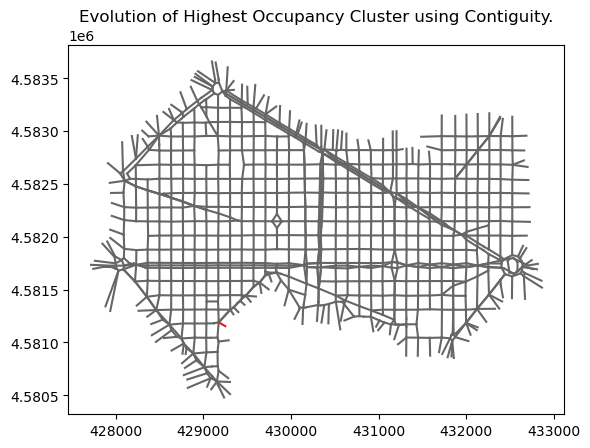

In [15]:
display_clustering_video('Occ')

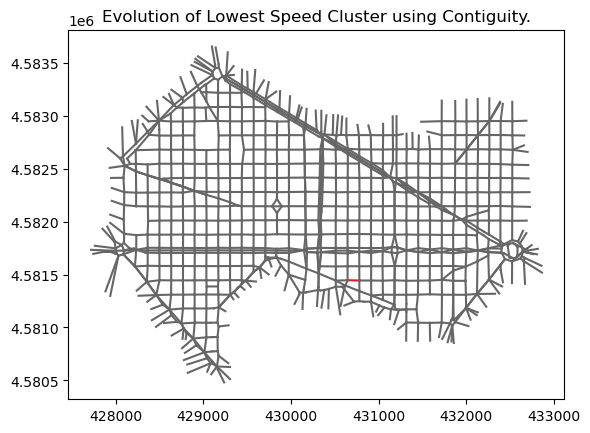

In [16]:
display_clustering_video('Speed')

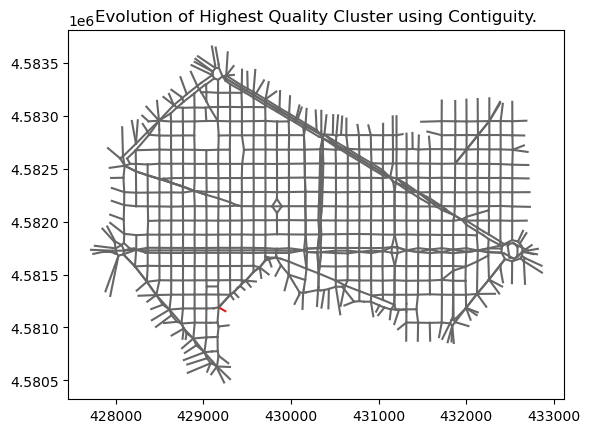

In [17]:
display_clustering_video('Quality')

In [82]:
from IPython.display import HTML
from matplotlib.patches import Rectangle
from matplotlib import colormaps

def create_graph_of_all_frames(mode, frames, title, filename):

    links_index = links.index.tolist()

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True)
    fig.set_size_inches(w=6, h=10)
    links_index = links.index.tolist()
    cmap = colormaps['tab10'].colors
    hot = colormaps['Set1'].colors[0]
    cold = colormaps['Dark2'].colors[-1]

    lines = [[], [], []]

    for (index, ax) in enumerate(axes):
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        for link in links_index:
            color = cmap[0]
            line, = ax.plot(positions.loc[link, ['StartNode_X', 'EndNode_X']], positions.loc[link, ['StartNode_Y', 'EndNode_Y']], color=color)
            lines[index].append(line)

    for (index, frame) in enumerate(frames):
        memberships_at_frame = memberships_per_time[frame]
        clusters_by_occ = clusters_per_frame_by_occ[frame]
        clusters_by_speed = clusters_per_frame_by_speed[frame]
        clusters_by_quality = qualities_per_cluster_per_frame[frame]
        
        if (mode == 'Occ'):
            top_cluster = clusters_by_occ.index[0]
        elif mode == 'Speed':
            top_cluster = clusters_by_speed.index[-1]
        elif mode == 'Quality':
            top_cluster = clusters_by_quality.index[-1]

        for i, _ in enumerate(links_index):
            value = memberships_at_frame[i]
            if (value == top_cluster):
                color = hot
            else:
                color = cold
            lines[index][i].set_color(color)

    axes[0].set_title(title)
    fig.savefig(fname=filename, bbox_inches='tight')
    fig.show()

In [93]:
from IPython.display import HTML
from matplotlib.patches import Rectangle
from matplotlib import colormaps

def create_graph_of_all_modes(frame, filename=""):

    links_index = links.index.tolist()

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True)
    fig.set_size_inches(w=6, h=10)
    links_index = links.index.tolist()
    cmap = colormaps['tab10'].colors
    hot = colormaps['Set1'].colors[0]
    cold = colormaps['Dark2'].colors[-1]

    lines = [[], [], []]
    modes = ['Speed', 'Occ', 'Quality']

    for (index, ax) in enumerate(axes):
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        for link in links_index:
            color = cmap[0]
            line, = ax.plot(positions.loc[link, ['StartNode_X', 'EndNode_X']], positions.loc[link, ['StartNode_Y', 'EndNode_Y']], color=color)
            lines[index].append(line)

    for (index, mode) in enumerate(modes):
        memberships_at_frame = memberships_per_time[frame]
        clusters_by_occ = clusters_per_frame_by_occ[frame]
        clusters_by_speed = clusters_per_frame_by_speed[frame]
        clusters_by_quality = qualities_per_cluster_per_frame[frame]
        
        if (mode == 'Occ'):
            top_cluster = clusters_by_occ.index[0]
            axes[index].set_title('Highest Occupancy Cluster at Peak Demand')
        elif mode == 'Speed':
            top_cluster = clusters_by_speed.index[-1]
            axes[index].set_title('Lowest Mean Speed Cluster at Peak Demand')
        elif mode == 'Quality':
            top_cluster = clusters_by_quality.index[-1]
            axes[index].set_title('Most Similar Cluster in Quality at Peak Demand')

        for i, _ in enumerate(links_index):
            value = memberships_at_frame[i]
            if (value == top_cluster):
                color = hot
            else:
                color = cold
            lines[index][i].set_color(color)

    if (filename != ""):
        fig.savefig(fname=filename, bbox_inches='tight')

    fig.suptitle('Comparison of Clusters Representing Traffic Conditions and Best Quality Cluster')
    fig.show()

/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1009112754.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


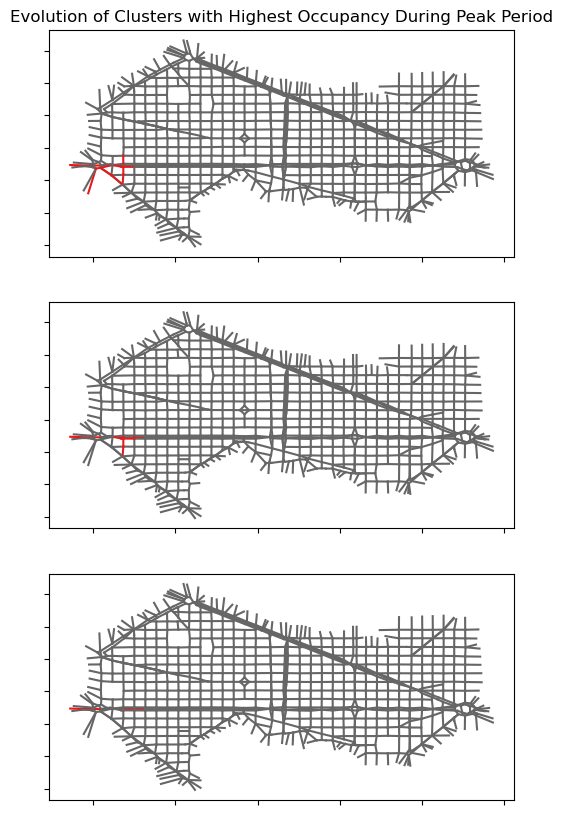

In [83]:
create_graph_of_all_frames('Occ', [13,14,15], 'Evolution of Clusters with Highest Occupancy During Peak Period', filename='over_time_occ.png')

/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1009112754.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


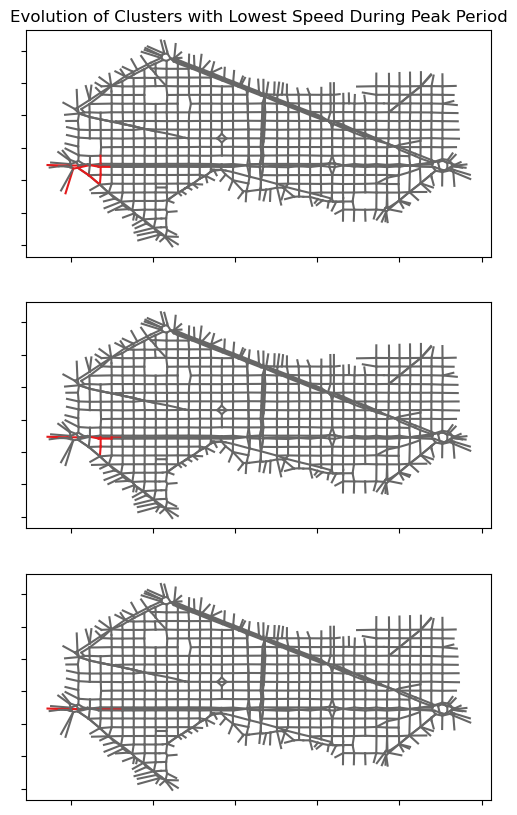

In [84]:
create_graph_of_all_frames('Speed', [13,14,15], 'Evolution of Clusters with Lowest Speed During Peak Period', filename='over_time_speed.png')

/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/1009112754.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


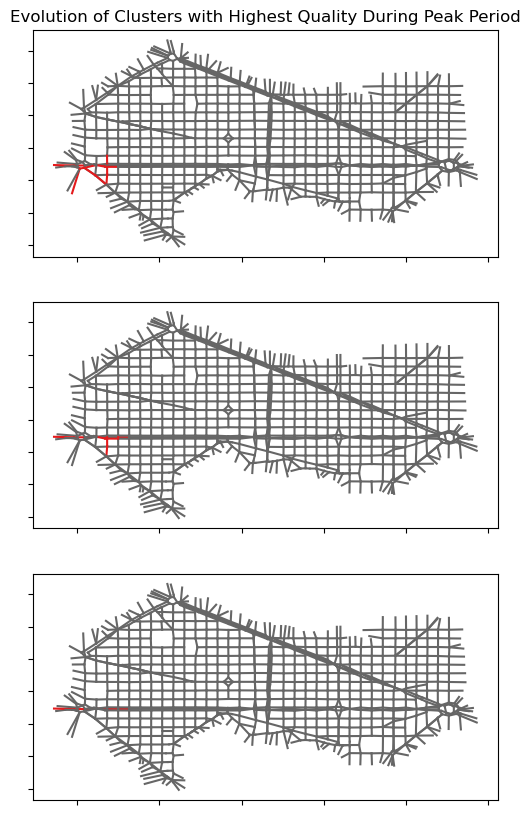

In [85]:
create_graph_of_all_frames('Quality', [13,14,15], 'Evolution of Clusters with Highest Quality During Peak Period', filename='over_time_quality.png')

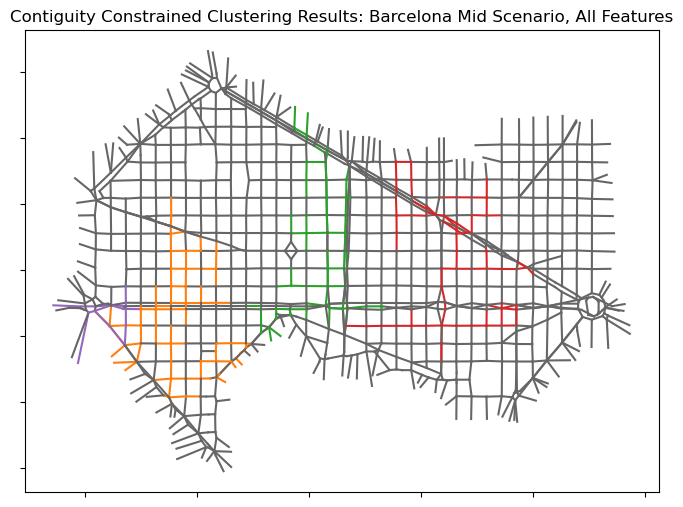

In [80]:
clusters = memberships_per_time[13]
plot_clusters(clusters, 'Contiguity Constrained Clustering Results: Barcelona Mid Scenario, All Features', filename='base_clustering_results.png')

/var/folders/kk/mdzq__5d3kq7hxxjy6h6y_tm0000gn/T/ipykernel_621/2564445695.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


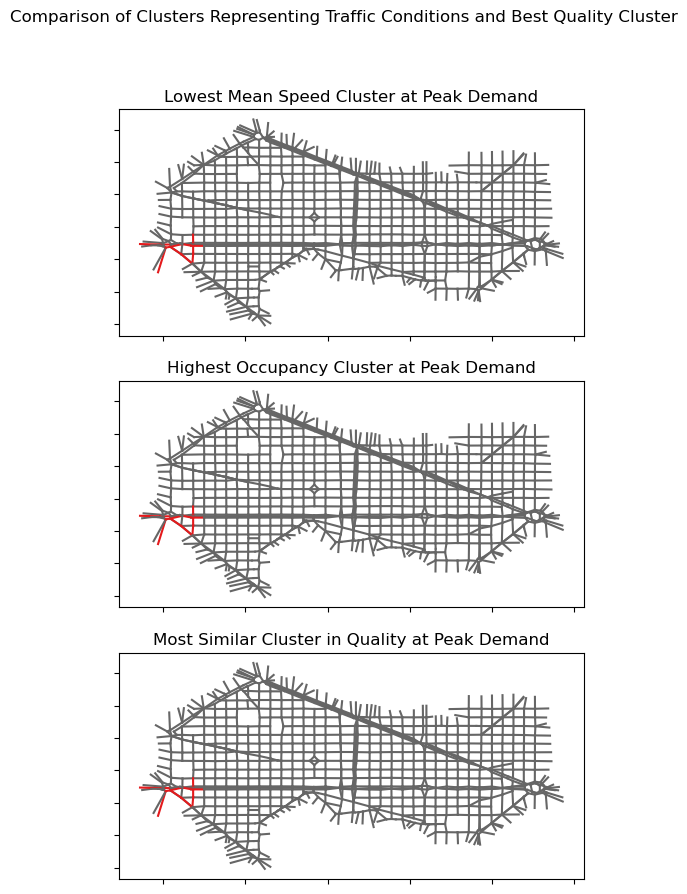

In [95]:
create_graph_of_all_modes(13, filename='modes_compared.png')

In [100]:
total_equal = 0
for (index, _) in enumerate(memberships_per_time):
    highest_occ_at_time = clusters_per_frame_by_occ[index].index[0]
    lowest_speed_at_time = clusters_per_frame_by_speed[index].index[-1]
    best_quality_at_time = qualities_per_cluster_per_frame[index].index[-1]

    if (highest_occ_at_time == best_quality_at_time or lowest_speed_at_time == best_quality_at_time):
        total_equal+=1

    print(f"At frame: {index} we have highest occ: {highest_occ_at_time}, lowest speed: {lowest_speed_at_time}, best quality {best_quality_at_time}")

print(f"percentage equal: {total_equal / len(memberships_per_time)}")

At frame: 0 we have highest occ: 4, lowest speed: 4, best quality 4
At frame: 1 we have highest occ: 4, lowest speed: 4, best quality 4
At frame: 2 we have highest occ: 3, lowest speed: 4, best quality 4
At frame: 3 we have highest occ: 2, lowest speed: 1, best quality 4
At frame: 4 we have highest occ: 4, lowest speed: 4, best quality 4
At frame: 5 we have highest occ: 1, lowest speed: 1, best quality 4
At frame: 6 we have highest occ: 1, lowest speed: 1, best quality 4
At frame: 7 we have highest occ: 2, lowest speed: 2, best quality 4
At frame: 8 we have highest occ: 1, lowest speed: 1, best quality 4
At frame: 9 we have highest occ: 1, lowest speed: 1, best quality 3
At frame: 10 we have highest occ: 4, lowest speed: 4, best quality 4
At frame: 11 we have highest occ: 3, lowest speed: 3, best quality 3
At frame: 12 we have highest occ: 2, lowest speed: 2, best quality 4
At frame: 13 we have highest occ: 4, lowest speed: 4, best quality 4
At frame: 14 we have highest occ: 4, lowest 

In [101]:
print(qualities_per_cluster_per_frame)

[Clusters
0    1236.613975
2     480.920191
1     371.401460
3      57.680514
4       9.269140
dtype: float64, Clusters
0    1181.558225
1     418.861815
2     147.196643
3     100.349820
4      18.224190
dtype: float64, Clusters
0    1239.383276
1     300.326092
2      61.537430
3      49.328076
4      22.307956
dtype: float64, Clusters
0    915.808996
2    168.000083
3    142.985325
1    129.980962
4    102.961198
dtype: float64, Clusters
0    953.559609
3    164.528351
1    142.007845
2    109.374655
4     61.230142
dtype: float64, Clusters
0    912.620994
2    293.602156
1    253.781750
3     70.786496
4      1.449190
dtype: float64, Clusters
2    488.084599
0    293.123808
3    234.547475
1    229.057694
4    201.330462
dtype: float64, Clusters
0    862.445811
1    419.009128
2     66.877808
3     51.299042
4     34.236421
dtype: float64, Clusters
1    536.725539
0    489.754024
2    204.768005
3     57.675756
4     25.322003
dtype: float64, Clusters
0    820.239890
1    220.15487